In [3]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 31.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 38.5 MB/s eta 0:00:00a 0:00:01


In [7]:
!pip install seaborn

In [5]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 28.9 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.2 MB/s eta 0:00:00


In [9]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

Running KNN with k=1, distance_metric=euclidean
Running KNN with k=1, distance_metric=manhattan
Running KNN with k=1, distance_metric=minkowski
Running KNN with k=3, distance_metric=euclidean
Running KNN with k=3, distance_metric=manhattan
Running KNN with k=3, distance_metric=minkowski
Running KNN with k=5, distance_metric=euclidean
Running KNN with k=5, distance_metric=manhattan
Running KNN with k=5, distance_metric=minkowski
Running KNN with k=7, distance_metric=euclidean
Running KNN with k=7, distance_metric=manhattan
Running KNN with k=7, distance_metric=minkowski
Running KNN with k=9, distance_metric=euclidean
Running KNN with k=9, distance_metric=manhattan
Running KNN with k=9, distance_metric=minkowski

Results Summary:
Configuration        Accuracy   Precision  Recall     F1 Score   Run Time  
------------------------------------------------------------
k=1, metric=euclidean 0.9420 0.9318 0.9113 0.9211 0.1165s
k=1, metric=manhattan 0.9508 0.9361 0.9340 0.9342 0.0953s
k=1, metr

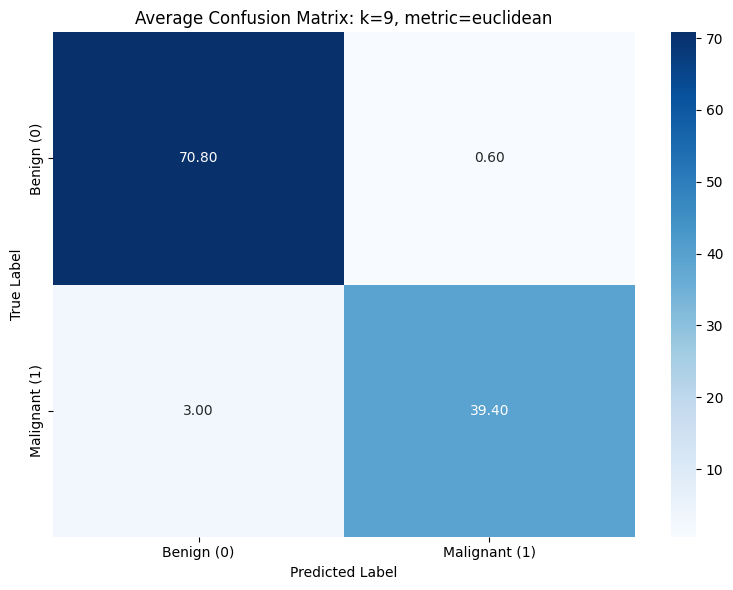

In [ ]:
# Step 1: -------- Load and prepare the dataset --------
def load_dataset():
    # Load the dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data"
    column_names = ['ID', 'Diagnosis'] + [f'Feature_{i}' for i in range(1, 31)]
    data = pd.read_csv(url, header=None, names=column_names)
    
    # Convert diagnosis to binary (M = 1, B = 0)
    data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})
    
    # Remove ID column
    data = data.drop('ID', axis=1)
    
    # Split into features and target
    X = data.drop('Diagnosis', axis=1).values
    y = data['Diagnosis'].values
    
    return X, y

# Step 2: -------- Develop custom distance functions ---------
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

def minkowski_distance(x1, x2, p=3):
    return np.power(np.sum(np.power(np.abs(x1 - x2), p)), 1/p)

# Step 3: -------- Implement KNN classifier --------
class KNNClassifier:
    def __init__(self, k=5, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def _calculate_distances(self, x):
        distances = []
        
        if self.distance_metric == 'euclidean':
            for i in range(len(self.X_train)):
                dist = euclidean_distance(x, self.X_train[i])
                distances.append((dist, self.y_train[i]))
        elif self.distance_metric == 'manhattan':
            for i in range(len(self.X_train)):
                dist = manhattan_distance(x, self.X_train[i])
                distances.append((dist, self.y_train[i]))
        elif self.distance_metric == 'minkowski':
            for i in range(len(self.X_train)):
                dist = minkowski_distance(x, self.X_train[i])
                distances.append((dist, self.y_train[i]))
        
        return distances
    
    def predict(self, X_test):
        y_pred = []
        
        for x in X_test:
            # Calculate distances
            distances = self._calculate_distances(x)
            
            # Sort distances and get k nearest neighbors
            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]
            
            # Get the most common class label
            k_nearest_labels = [label for _, label in k_nearest]
            majority_vote = max(set(k_nearest_labels), key=k_nearest_labels.count)
            
            y_pred.append(majority_vote)
            
        return np.array(y_pred)

# Step 4: Implement k-fold cross-validation
def k_fold_cross_validation(X, y, k_neighbors, distance_metric, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Initialize metrics
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    conf_matrices = []
    run_times = []
    
    # Normalize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Create and train KNN model
        knn = KNNClassifier(k=k_neighbors, distance_metric=distance_metric)
        
        # Start timer
        start_time = time.time()
        
        # Train and predict
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        # End timer
        end_time = time.time()
        run_time = end_time - start_time
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Store results
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        conf_matrices.append(conf_matrix)
        run_times.append(run_time)
    
    return {
        'accuracy': np.mean(accuracy_scores),
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f1': np.mean(f1_scores),
        'conf_matrices': conf_matrices,
        'run_time': np.mean(run_times)
    }

# Step 5: Run experiments with different k values and distance metrics
def run_experiments():
    X, y = load_dataset()
    
    k_values = [1, 3, 5, 7, 9]
    distance_metrics = ['euclidean', 'manhattan', 'minkowski']
    
    results = {}
    
    for k in k_values:
        for metric in distance_metrics:
            print(f"Running KNN with k={k}, distance_metric={metric}")
            key = f"k={k}, metric={metric}"
            results[key] = k_fold_cross_validation(X, y, k, metric)
            
    return results

# Step 6: Create a function to plot confusion matrix
def plot_confusion_matrix(conf_matrices, title):
    avg_conf_matrix = np.mean(conf_matrices, axis=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['Benign (0)', 'Malignant (1)'],
                yticklabels=['Benign (0)', 'Malignant (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Average Confusion Matrix: {title}')
    plt.tight_layout()
    plt.show()

# Step 7: Main function to run the evaluation
def main():
    results = run_experiments()
    
    # Display results
    print("\nResults Summary:")
    print("=" * 60)
    print(f"{'Configuration':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'Run Time':<10}")
    print("-" * 60)
    
    for config, metrics in results.items():
        print(f"{config:<20} {metrics['accuracy']:.4f} {metrics['precision']:.4f} {metrics['recall']:.4f} {metrics['f1']:.4f} {metrics['run_time']:.4f}s")
    
    # Find the best configuration
    best_config = max(results.items(), key=lambda x: x[1]['f1'])
    print("\nBest Configuration:")
    print(f"- {best_config[0]}")
    print(f"- F1 Score: {best_config[1]['f1']:.4f}")
    print(f"- Accuracy: {best_config[1]['accuracy']:.4f}")
    
    # Plot confusion matrix for the best configuration
    plot_confusion_matrix(best_config[1]['conf_matrices'], best_config[0])

if __name__ == "__main__":
    main()